In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import check_nan, check_unique
from matplotlib import gridspec
from matplotlib import rcParams
#Paramètres graphiques 
rcParams['figure.figsize'] = 15,8 #Taille de la figure affichée
sns.set_style("darkgrid")#style de l'arrière plan de seaborn 
sns.set_palette("pastel")#Couleurs utilisées dans les graphiques 
plt.rcParams["figure.dpi"] = 200 #dpi = dot per inch , résolution des graphiques 
pd.set_option('display.max_columns', 500) #Nombre de colonne maximum du dataframe à afficher

import warnings
warnings.simplefilter(action='ignore')

# Lecture et mise en forme des données

# Mise en forme des données :

In [110]:
data=pd.read_csv("./data/delays.csv")
data.columns= ["save_datetime","id_train_complet","transporteur","date_depart","depart_destination","arrivee_prevue","retard","nom_station"]

data["save_datetime"]=pd.to_datetime(data["save_datetime"])
data["date_depart"]=pd.to_datetime(data["date_depart"])


#Drop des lignes avec une horaire prévue inexploitatble :
df=data[data["arrivee_prevue"]!='Nie dotyczy']


#Conversion du retard en entier : 
df["retard"]=df["retard"].apply(lambda x : int(x.split(" ")[0]))

#df[["depart","destination"]]= df["depart_destination"].str.split(" - ", expand=True)

new_id=df["id_train_complet"].str.extract(r"(\d+)(\/\d+)?\s*(\(\d+\)|)?(\s*)(.*|[a-zA-Z\u00C0-\u017F]*)").add_prefix('index_part')
df=df.merge(new_id, left_index=True, right_index=True).drop(['index_part3'], axis=1).rename(columns={"index_part4": "index_part3","index_part0":"id_train"})

df=df.fillna("")

#On ne garde que les lignes qui nous intéressent 
df =df.sort_values("save_datetime").drop_duplicates(["id_train_complet","transporteur","date_depart","depart_destination","arrivee_prevue","nom_station"],keep="last").sort_values("save_datetime")

df["arrivee_prevue"]=pd.to_datetime(df["arrivee_prevue"], format='%H:%M').dt.time

print("Shape du dataset d'origine :", data.shape)
print("Shape du dataset contenant uniquement les lignes qui nous intéressent : ",df.shape)
df.head()

Shape du dataset d'origine : (3718170, 8)
Shape du dataset contenant uniquement les lignes qui nous intéressent :  (264141, 12)


,save_datetime,id_train_complet,transporteur,date_depart,depart_destination,arrivee_prevue,retard,nom_station,id_train,index_part1,index_part2,index_part3
175,2022-05-16,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdańsk Zaspa - Wejherowo,23:38:00,24,Reda Pieleszewo,95697,,,
68,2022-05-16,91888/9,Koleje Mazowieckie,2022-05-16,Siedlce - Warszawa Zachodnia,00:01:00,2,Warszawa Stadion,91888,/9,,
111,2022-05-16,59486,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdynia Cisowa - Gdańsk Główny,23:54:00,9,Gdańsk Żabianka-AWFiS,59486,,,
119,2022-05-16,95699,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Śródmieście - Wejherowo,00:04:00,0,Gdynia Wzgórze Św.Maksymiliana,95699,,,
116,2022-05-16,95699,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Śródmieście - Wejherowo,00:01:00,0,Gdynia Redłowo,95699,,,


In [111]:
check_nan(df)
print("\n")
check_unique(df)

Valeurs nan dans save_datetime : 0
Valeurs nan dans id_train_complet : 0
Valeurs nan dans transporteur : 0
Valeurs nan dans date_depart : 0
Valeurs nan dans depart_destination : 0
Valeurs nan dans arrivee_prevue : 0
Valeurs nan dans retard : 0
Valeurs nan dans nom_station : 0
Valeurs nan dans id_train : 0
Valeurs nan dans index_part1 : 0
Valeurs nan dans index_part2 : 0
Valeurs nan dans index_part3 : 0


Valeurs uniques dans save_datetime : 4024
Valeurs uniques dans id_train_complet : 7947
Valeurs uniques dans transporteur : 10
Valeurs uniques dans date_depart : 16
Valeurs uniques dans depart_destination : 995
Valeurs uniques dans arrivee_prevue : 1390
Valeurs uniques dans retard : 263
Valeurs uniques dans nom_station : 95
Valeurs uniques dans id_train : 3447
Valeurs uniques dans index_part1 : 11
Valeurs uniques dans index_part2 : 75
Valeurs uniques dans index_part3 : 335


#### On a fortement réduit la taille du dataset 

# Observations sur les id_train  : 

# Feature preprocessing : 

## Extraction de départ - destination : 

In [101]:
df[['depart','destination']] = df["depart_destination"].str.split(" - ",expand=True,)
df.head()

,save_datetime,id_train_complet,transporteur,date_depart,depart_destination,arrivee_prevue,retard,nom_station,id_train,index_part1,index_part2,index_part3,depart,destination
175,2022-05-16,95697,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdańsk Zaspa - Wejherowo,23:38,24,Reda Pieleszewo,95697,,,,Gdańsk Zaspa,Wejherowo
68,2022-05-16,91888/9,Koleje Mazowieckie,2022-05-16,Siedlce - Warszawa Zachodnia,00:01,2,Warszawa Stadion,91888,/9,,,Siedlce,Warszawa Zachodnia
111,2022-05-16,59486,PKP SKM w Trójmieście Sp. z o.o.,2022-05-15,Gdynia Cisowa - Gdańsk Główny,23:54,9,Gdańsk Żabianka-AWFiS,59486,,,,Gdynia Cisowa,Gdańsk Główny
119,2022-05-16,95699,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Śródmieście - Wejherowo,00:04,0,Gdynia Wzgórze Św.Maksymiliana,95699,,,,Gdańsk Śródmieście,Wejherowo
116,2022-05-16,95699,PKP SKM w Trójmieście Sp. z o.o.,2022-05-16,Gdańsk Śródmieście - Wejherowo,00:01,0,Gdynia Redłowo,95699,,,,Gdańsk Śródmieście,Wejherowo


# Exploration des données : 

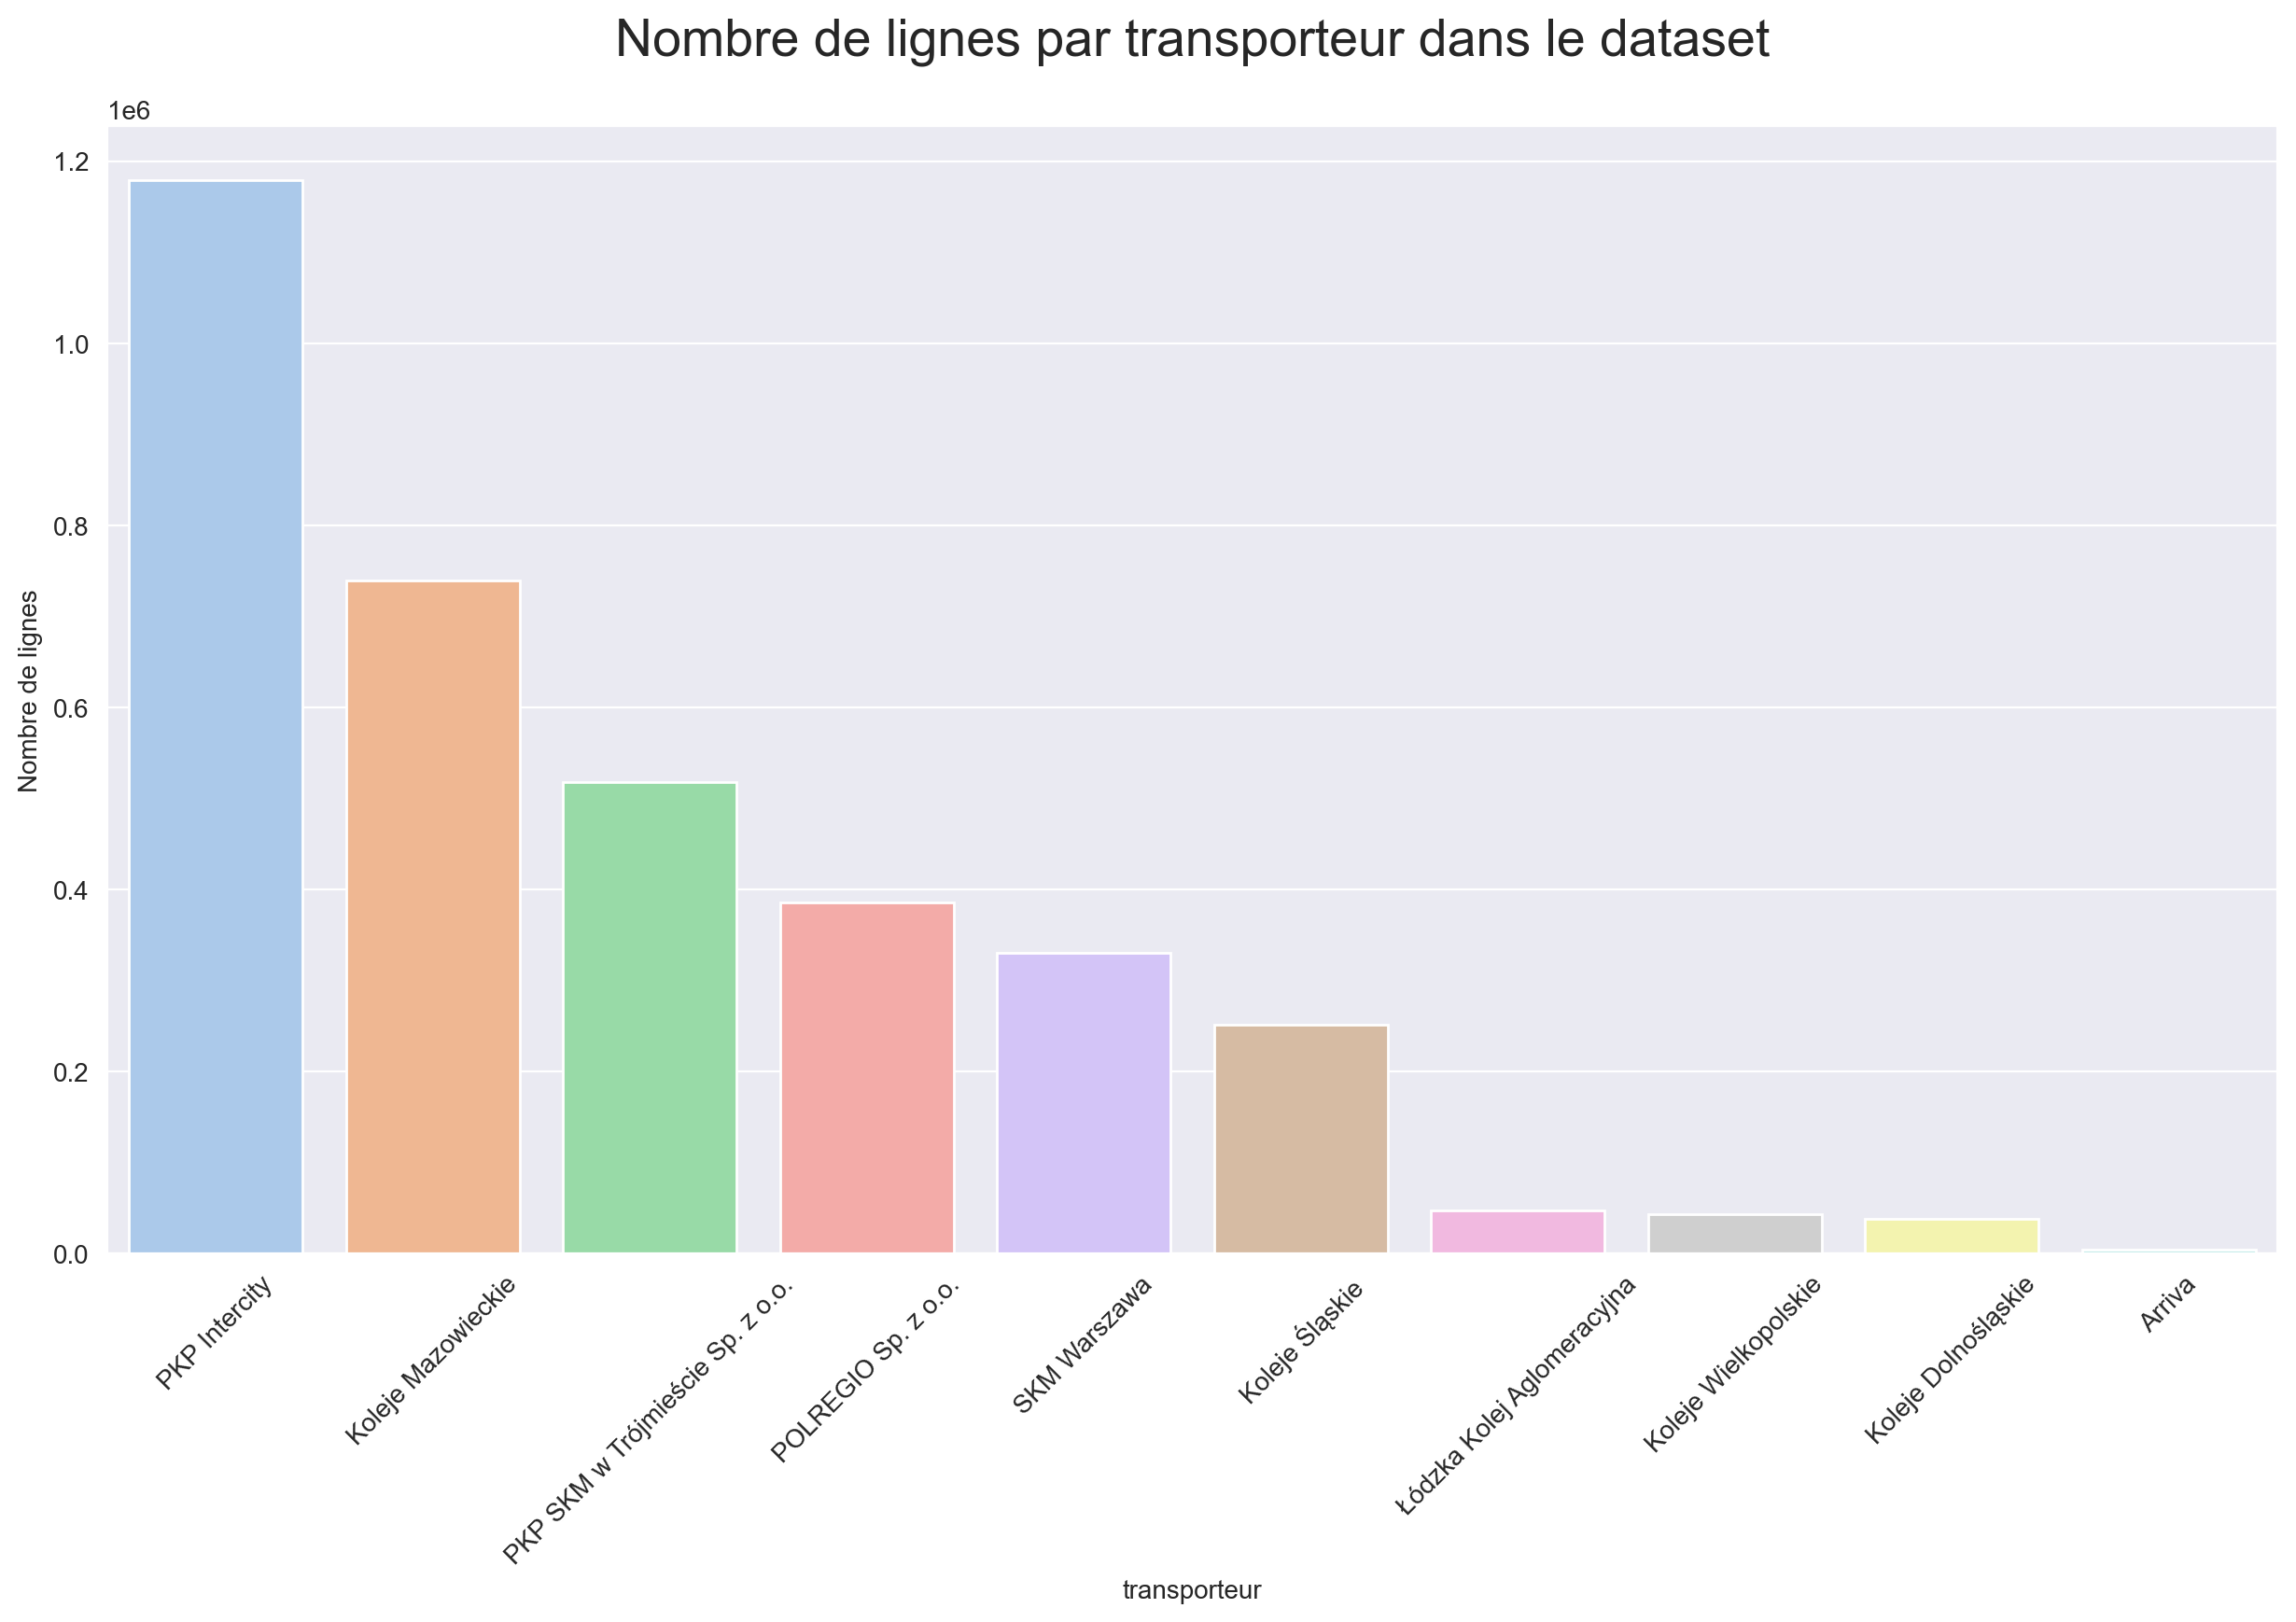

In [5]:
sns.barplot(data=df.groupby("transporteur").agg("count").sort_values("id_train",ascending=False).rename(columns={"id_train":"Nombre de lignes"}).reset_index(), 
            x="transporteur",
            y="Nombre de lignes")
plt.title("Nombre de lignes par transporteur dans le dataset\n",fontsize=20)
plt.xticks(rotation=45)
plt.show()

In [247]:
#Nombre moyen de lignes enregistrées toutes les 5 minutes 
df.groupby("datetime_save").agg("count").mean()

id_train           877.316468
transporteur       877.316468
trajet             877.316468
depart             877.316468
destination        877.316468
date_depart        877.316468
horaire_arrivee    877.316468
station_traitee    877.316468
retard_prevu       877.316468
heure_arrivee      877.316468
min_arrivee        877.128472
dtype: float64

In [180]:
df[(df["id_train"]=='10102/3  ZAMENHOF')  & (df["datetime_save"]==datetime.strptime('2022-05-17 20:10:00','%Y-%m-%d %H:%M:%S'))]

,id_train,transporteur,trajet,depart,destination,date_depart,horaire_arrivee,datetime_save,last_station,retard_prevu,heure_arrivee,min_arrivee
517008,10102/3 ZAMENHOF,PKP Intercity,Warszawa Zachodnia - Białystok,Warszawa Zachodnia,Białystok,2022-05-17,20:18,2022-05-17 20:10:00,Warszawa Centralna,0,20,18
517180,10102/3 ZAMENHOF,PKP Intercity,Warszawa Zachodnia - Białystok,Warszawa Zachodnia,Białystok,2022-05-17,20:30,2022-05-17 20:10:00,Warszawa Wschodnia,0,20,30


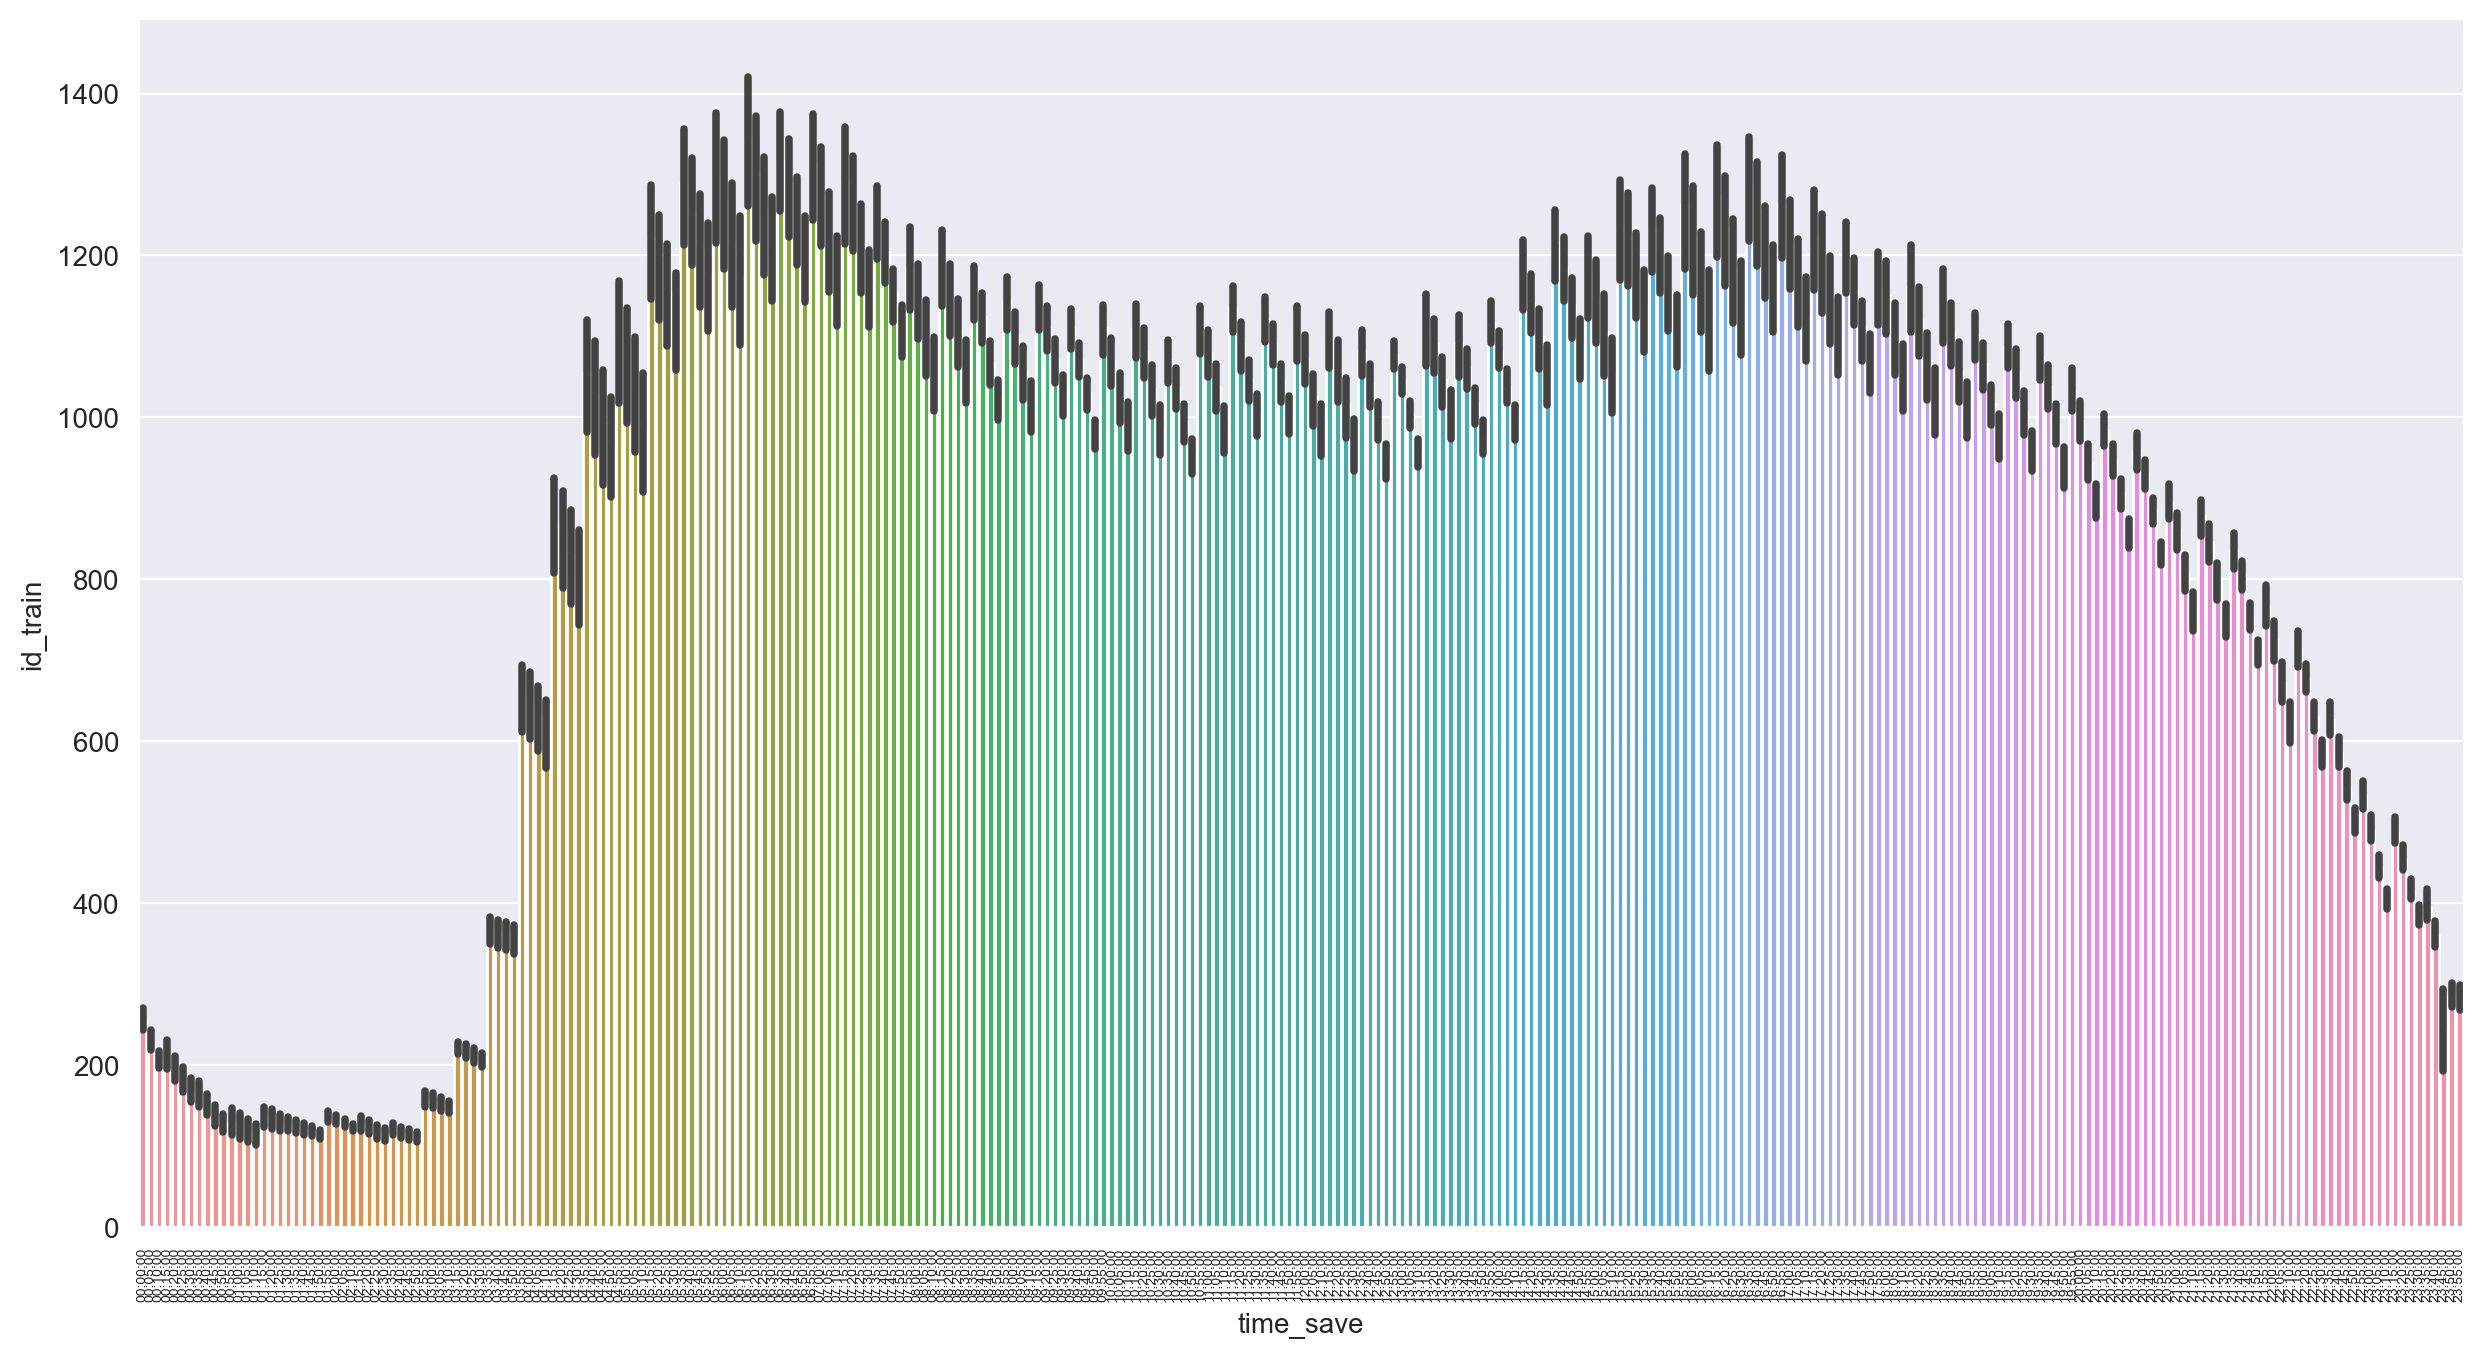

In [211]:
df_temp =df.copy(deep=True)
df_temp["date_save"]=df_temp["datetime_save"].dt.date
df_temp["time_save"]=df_temp["datetime_save"].dt.time

sns.barplot(data=df_temp.groupby(["date_save","time_save"]).agg("count").reset_index().sort_values("time_save"),
           x="time_save",y="id_train")
plt.xticks(rotation=90, fontsize=5)
plt.show()

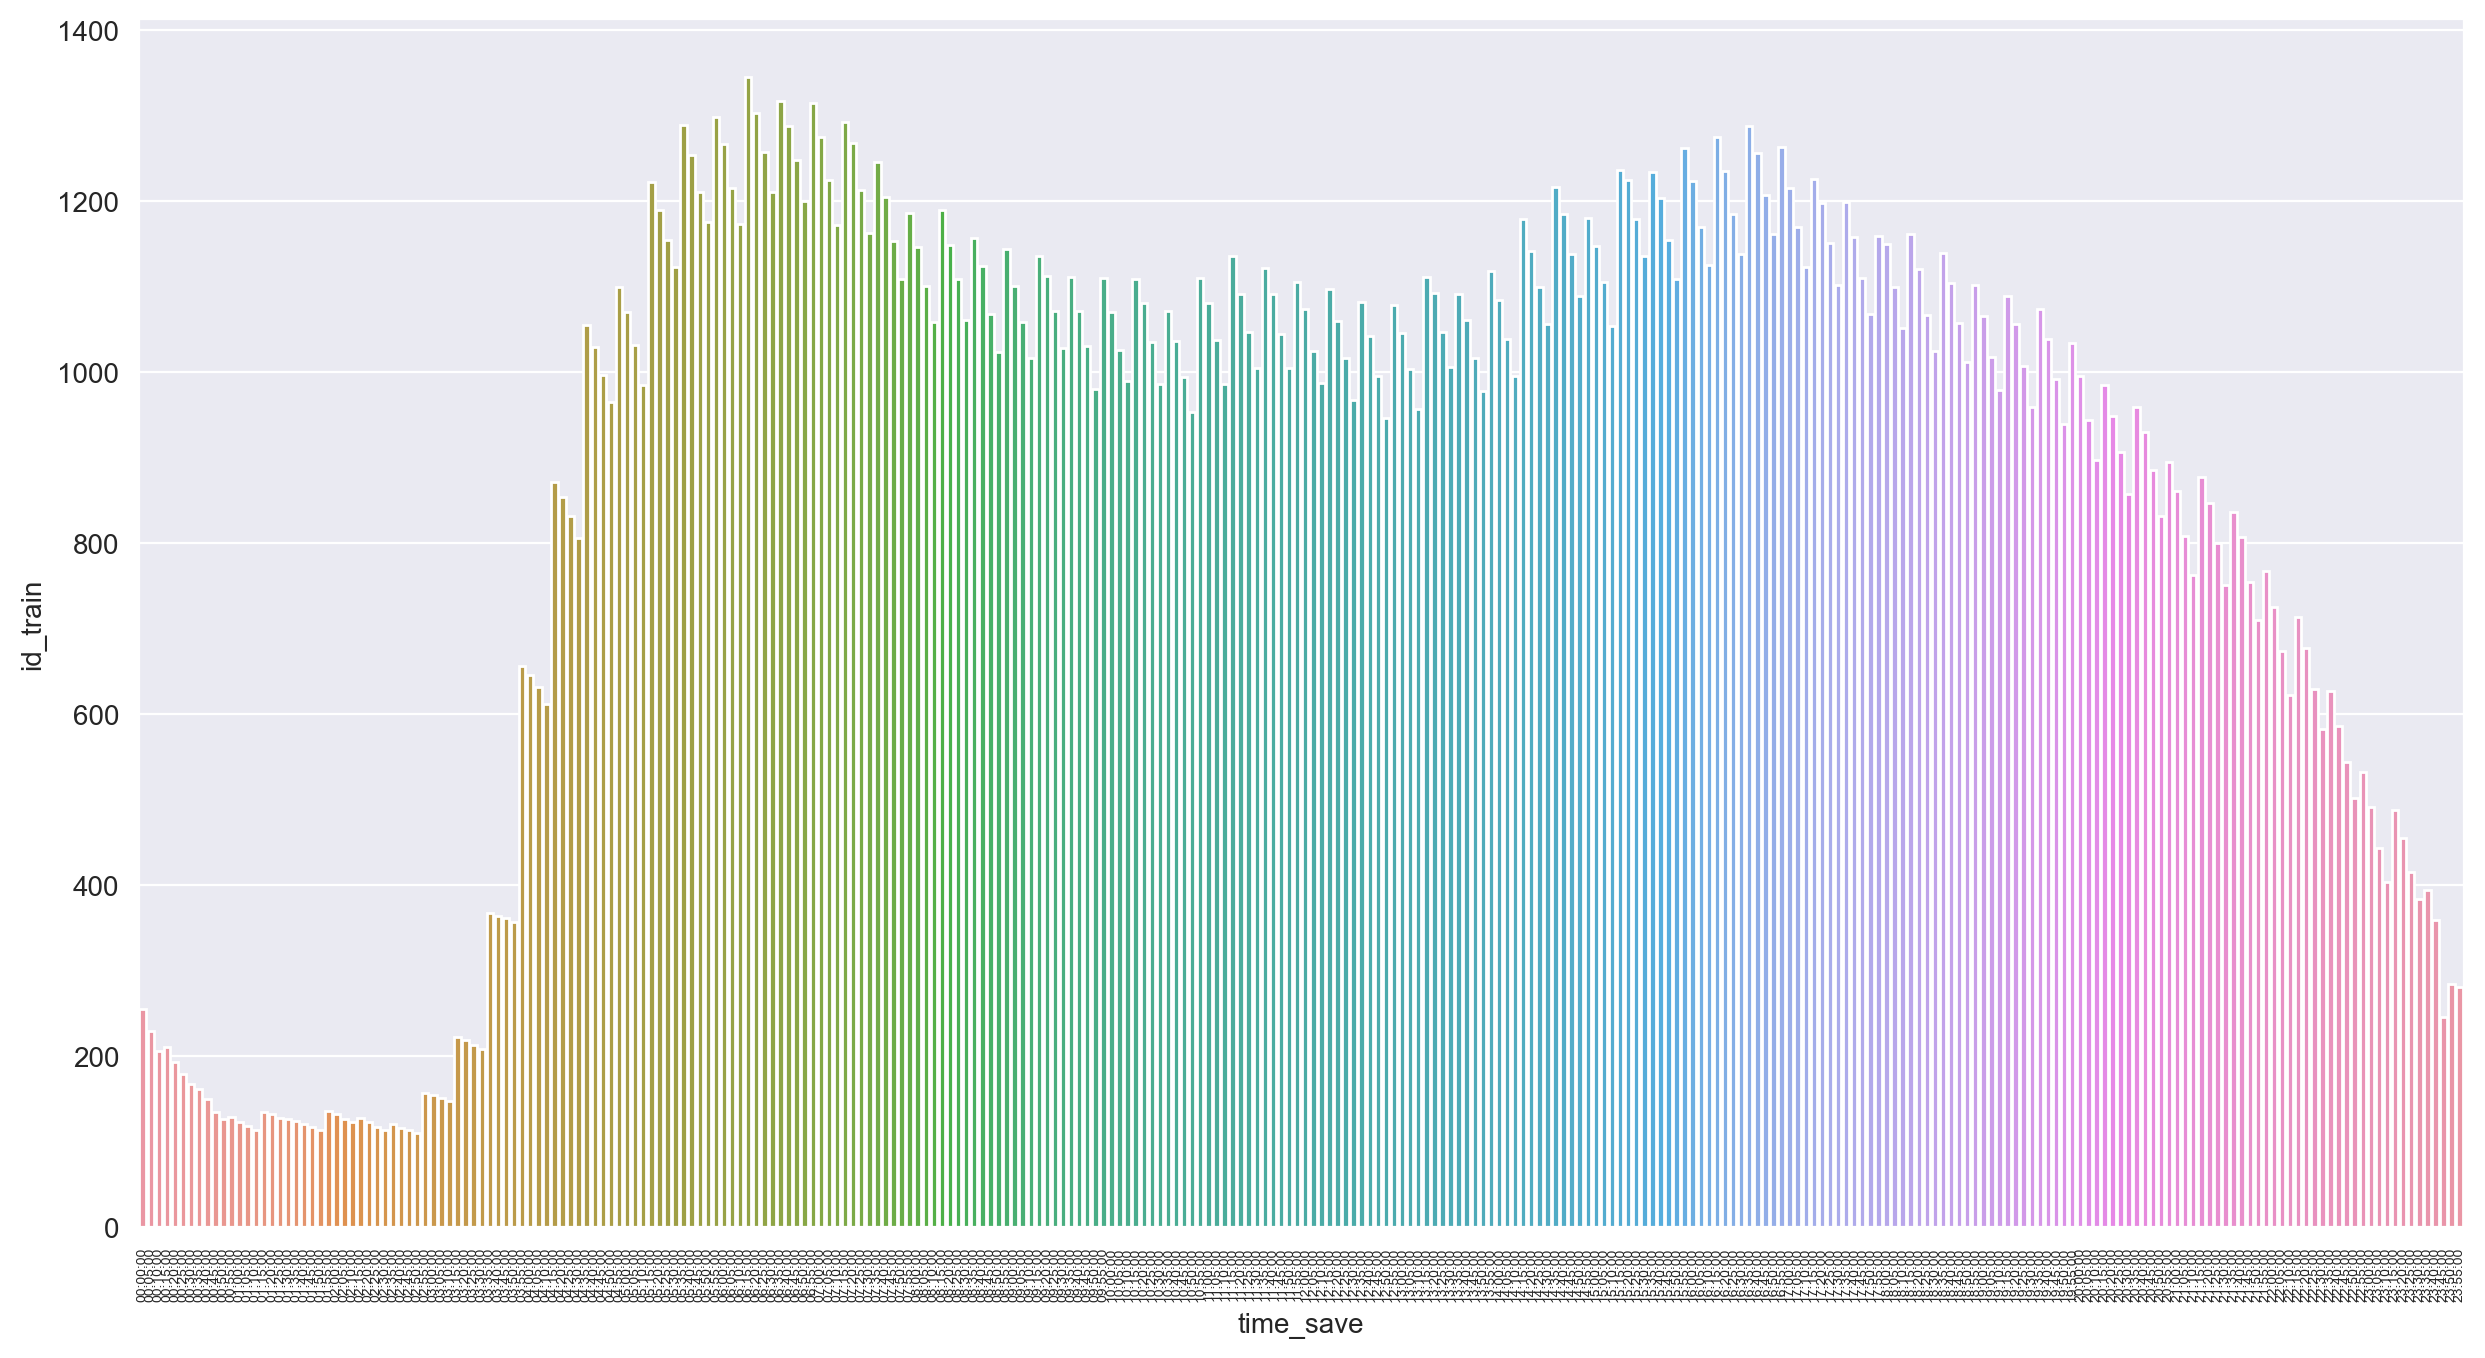

In [207]:
df_temp =df.copy(deep=True)
df_temp["date_save"]=df_temp["datetime_save"].dt.date
df_temp["time_save"]=df_temp["datetime_save"].dt.time

sns.barplot(data=df_temp.groupby(["date_save","time_save"]).agg("count").reset_index().groupby("time_save").agg("mean").reset_index().sort_values("time_save"),
           x="time_save",y="id_train")
plt.xticks(rotation=90, fontsize=5)
plt.show()

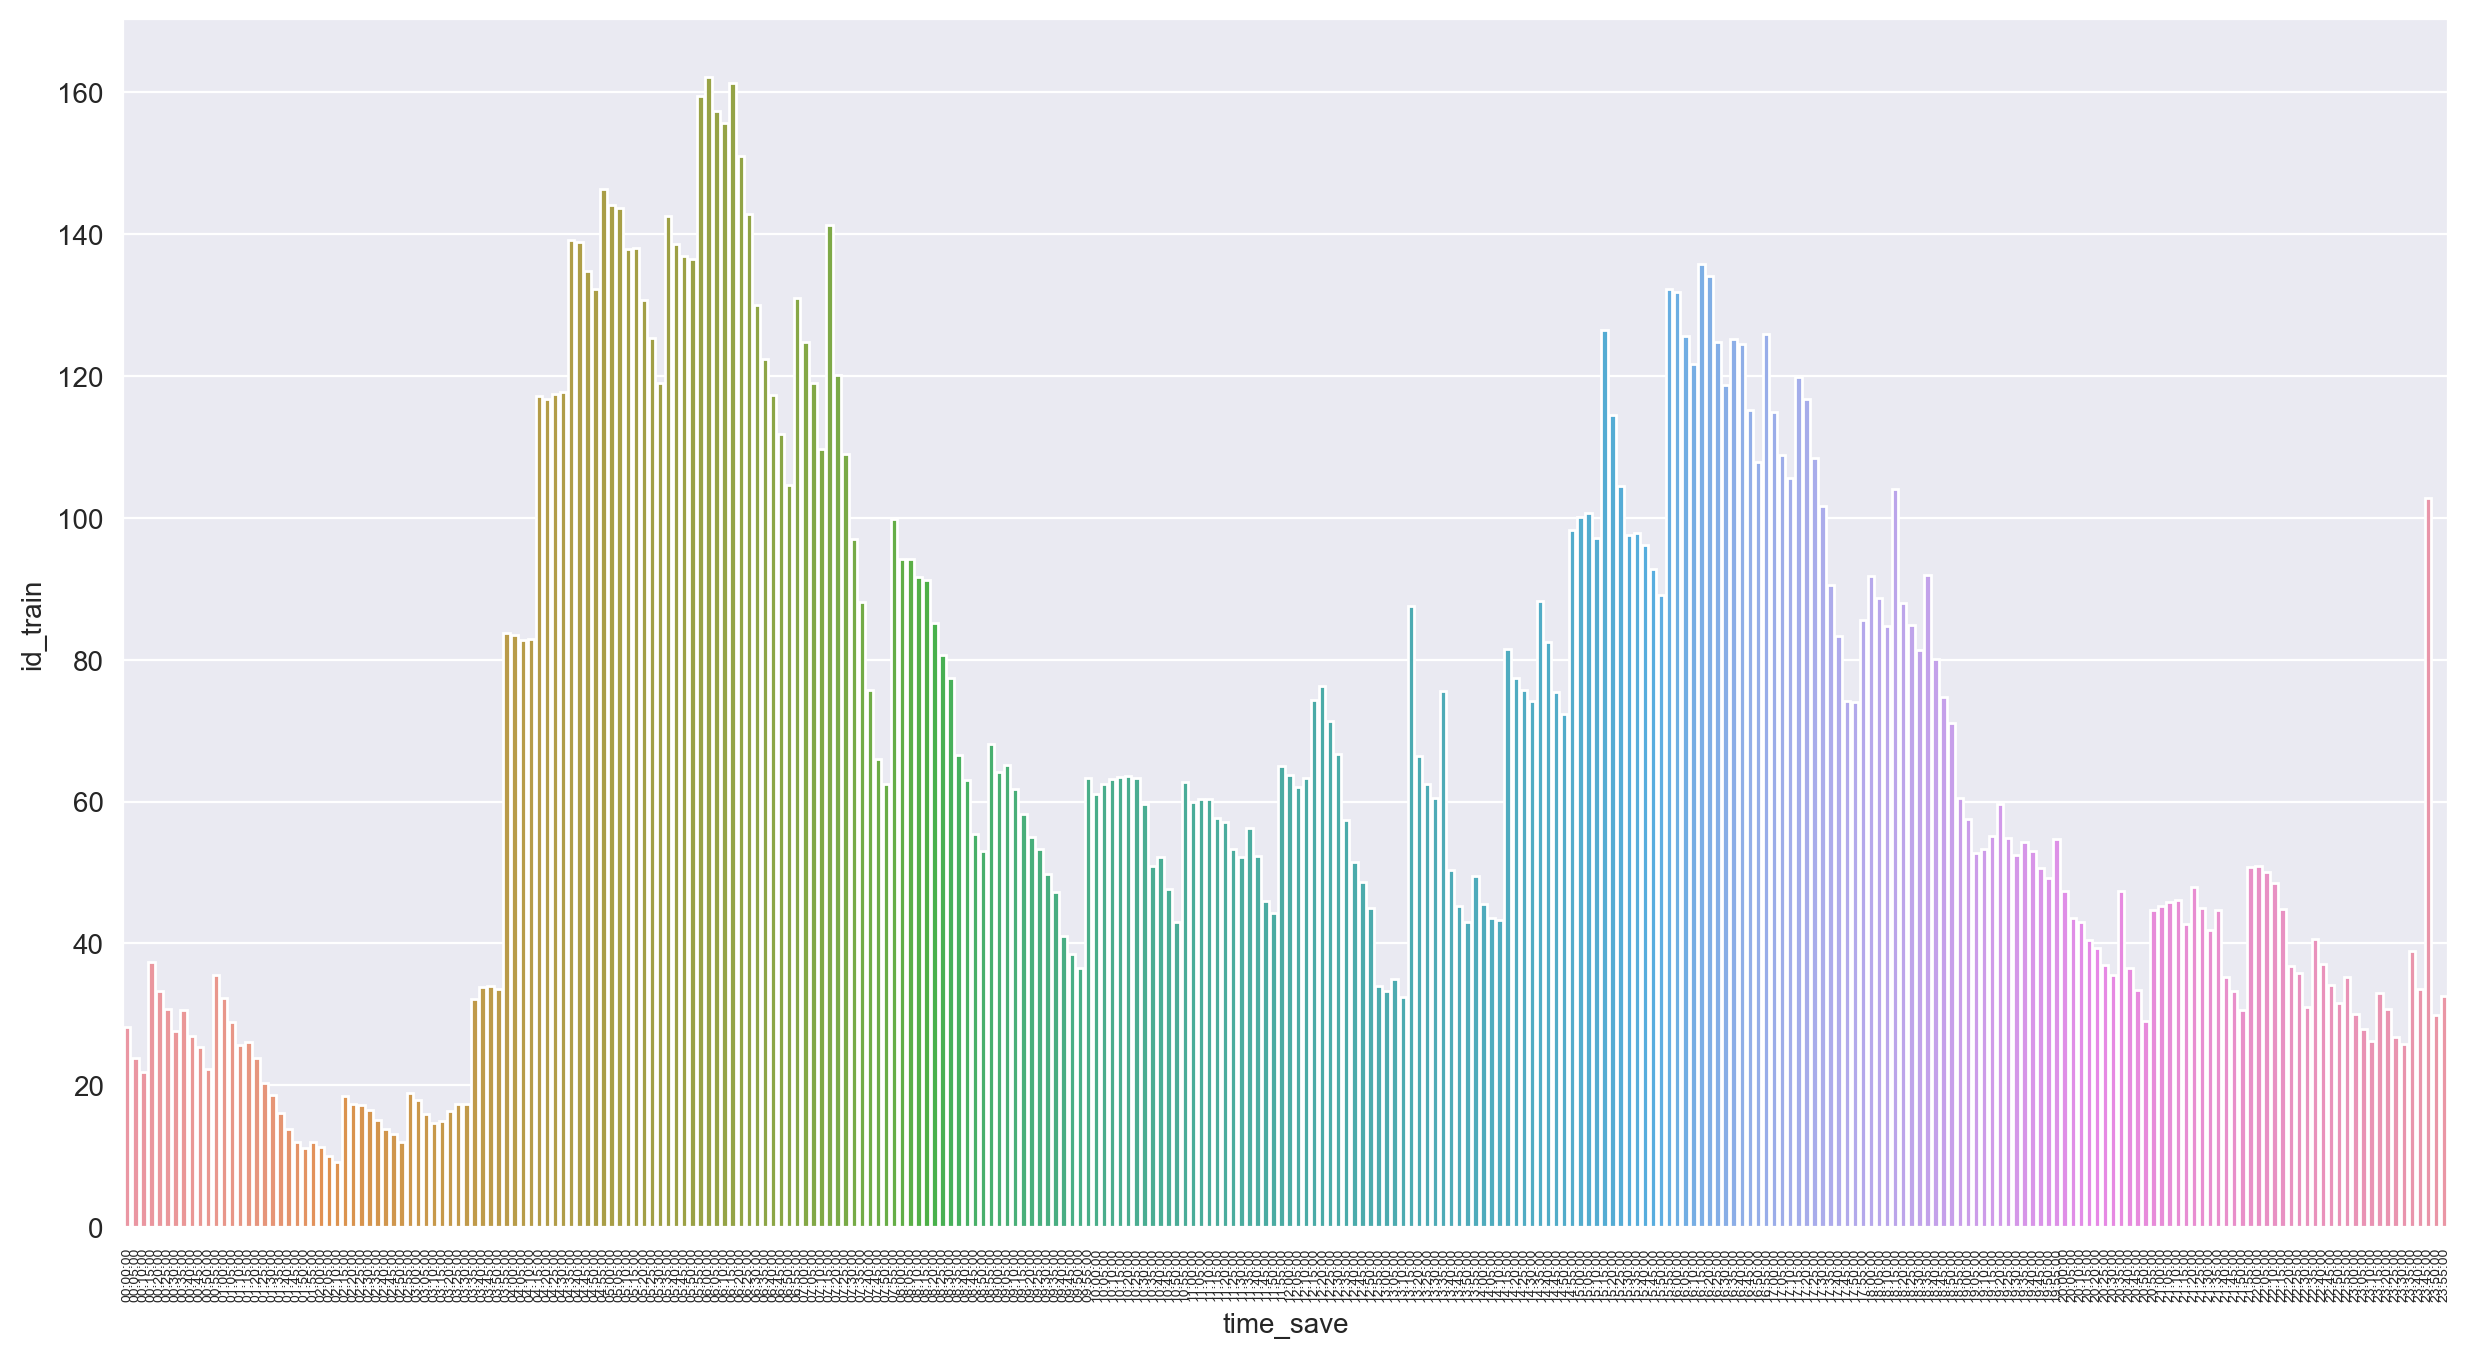

In [204]:
df_temp =df.copy(deep=True)
df_temp["date_save"]=df_temp["datetime_save"].dt.date
df_temp["time_save"]=df_temp["datetime_save"].dt.time

sns.barplot(data=df_temp.groupby(["date_save","time_save"]).agg("count").reset_index().groupby("time_save").agg("std").reset_index().sort_values("time_save"),
           x="time_save",y="id_train")


plt.xticks(rotation=90, fontsize=5)
plt.show()

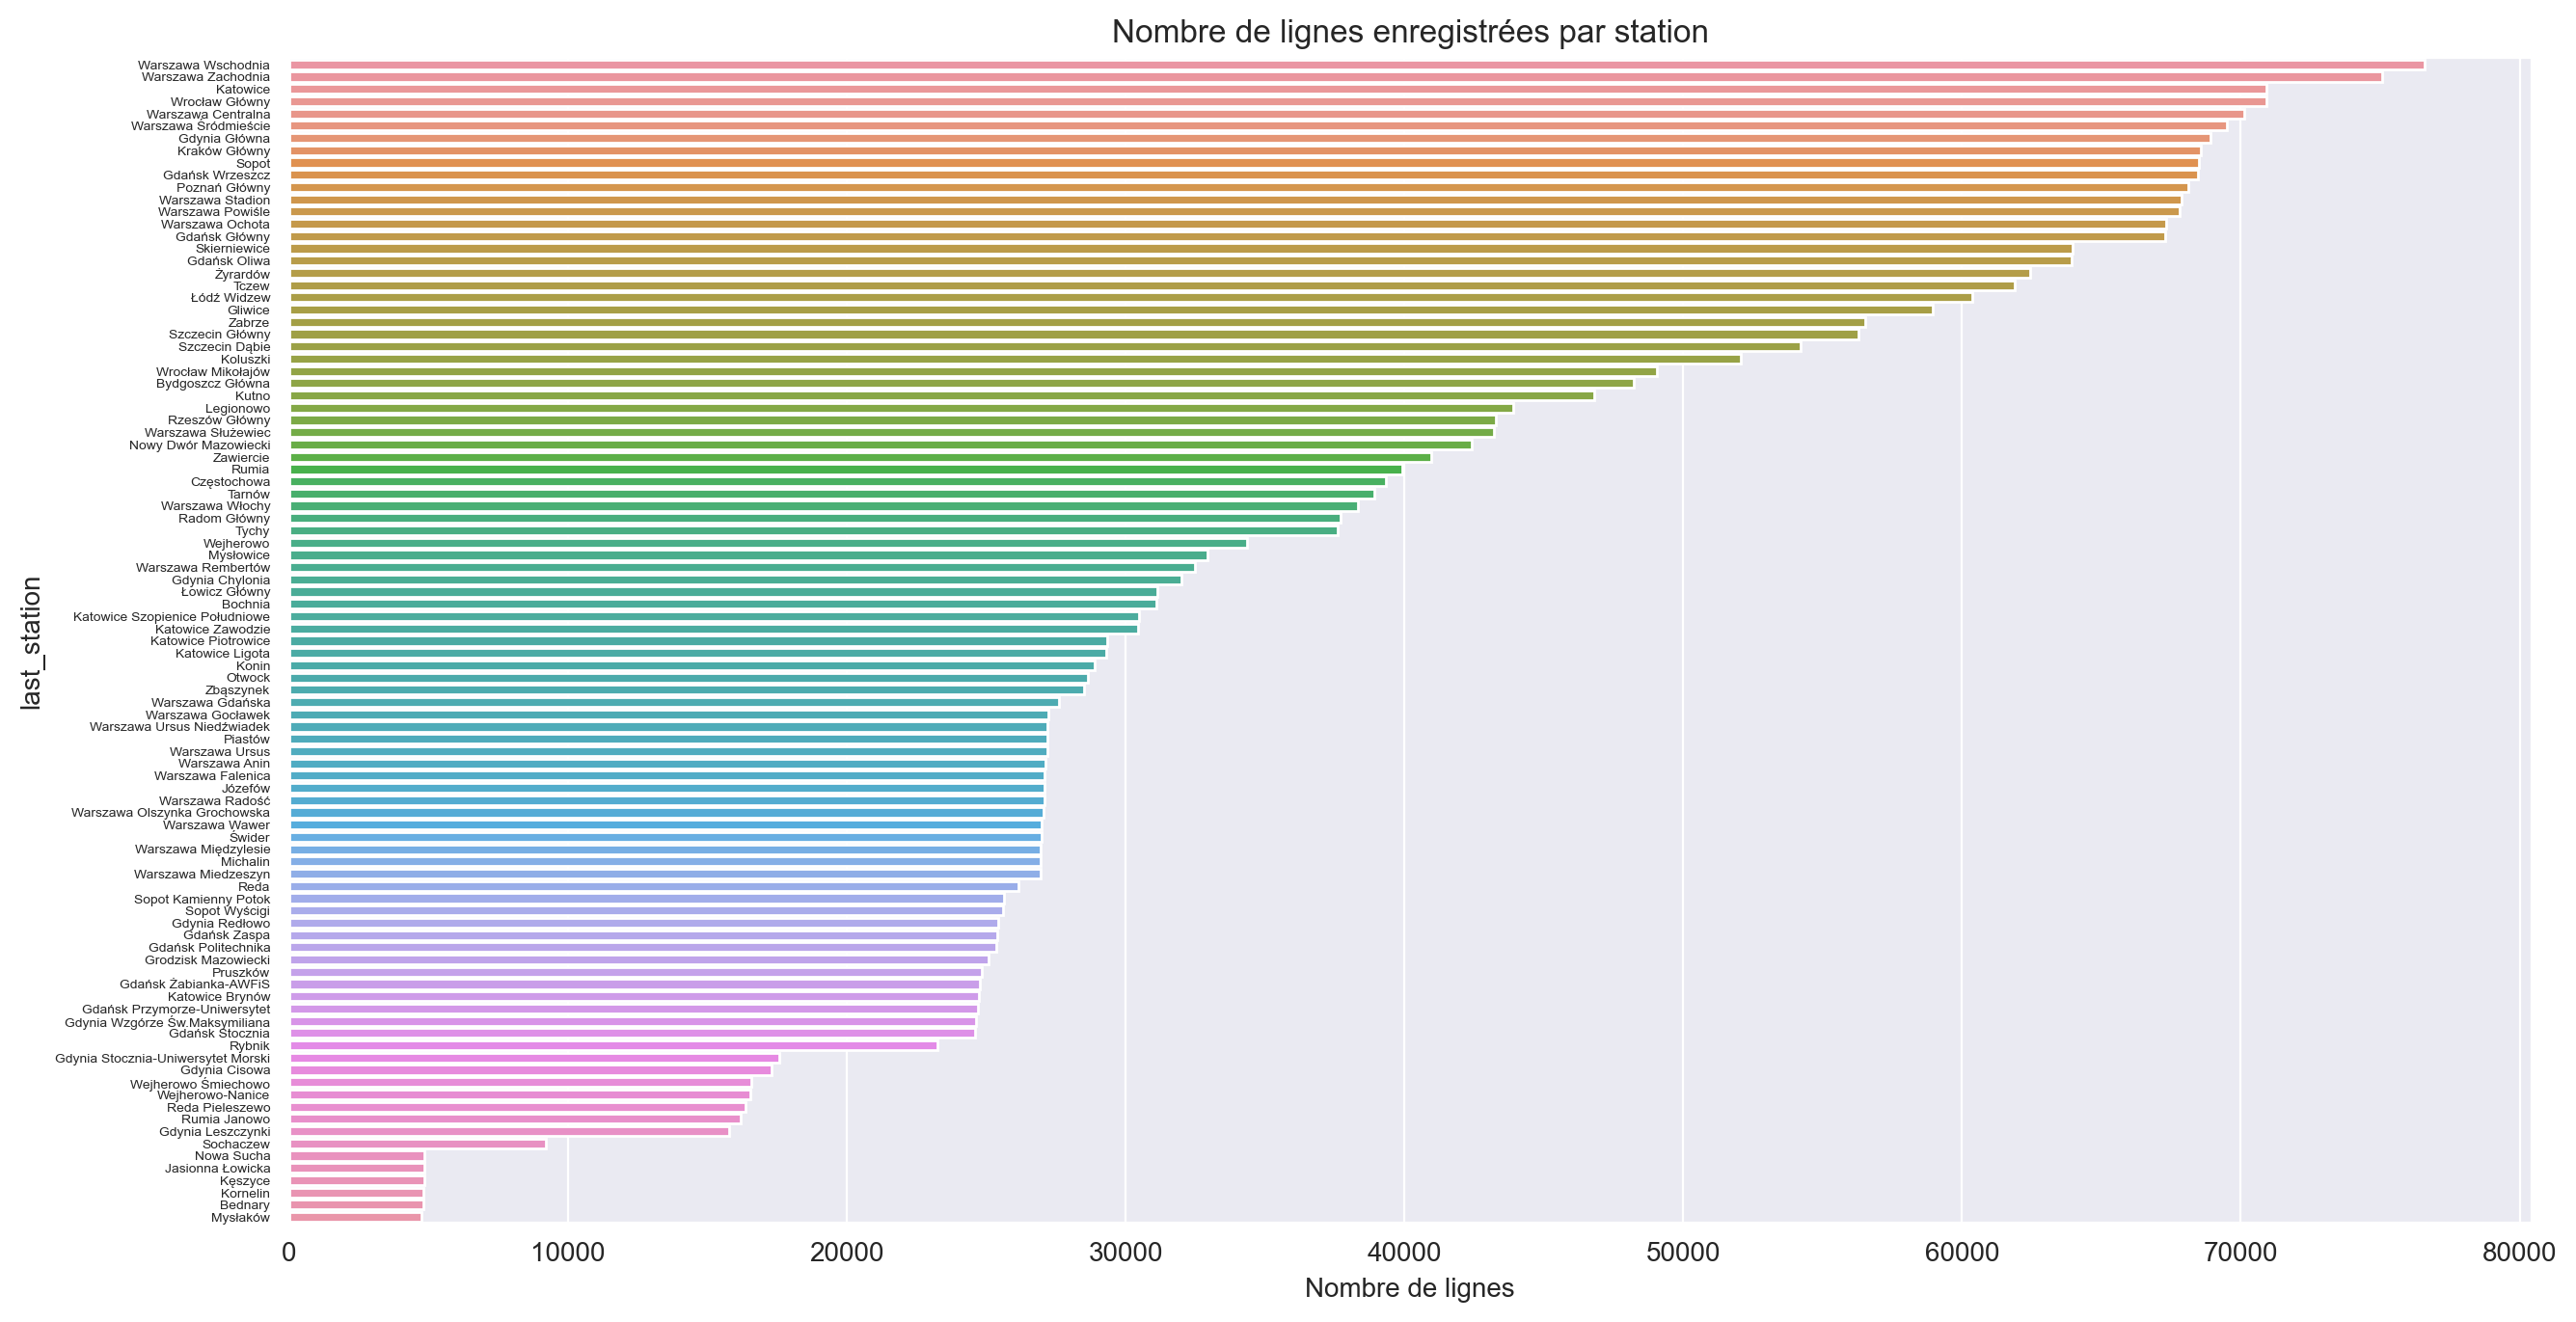

In [222]:
sns.barplot(data=df.groupby(["last_station"]).agg("count").reset_index().sort_values("retard_prevu",ascending=False),x="retard_prevu",y="last_station")

plt.yticks(fontsize=5)
plt.title("Nombre de lignes enregistrées par station")
plt.xlabel("Nombre de lignes")
plt.show()

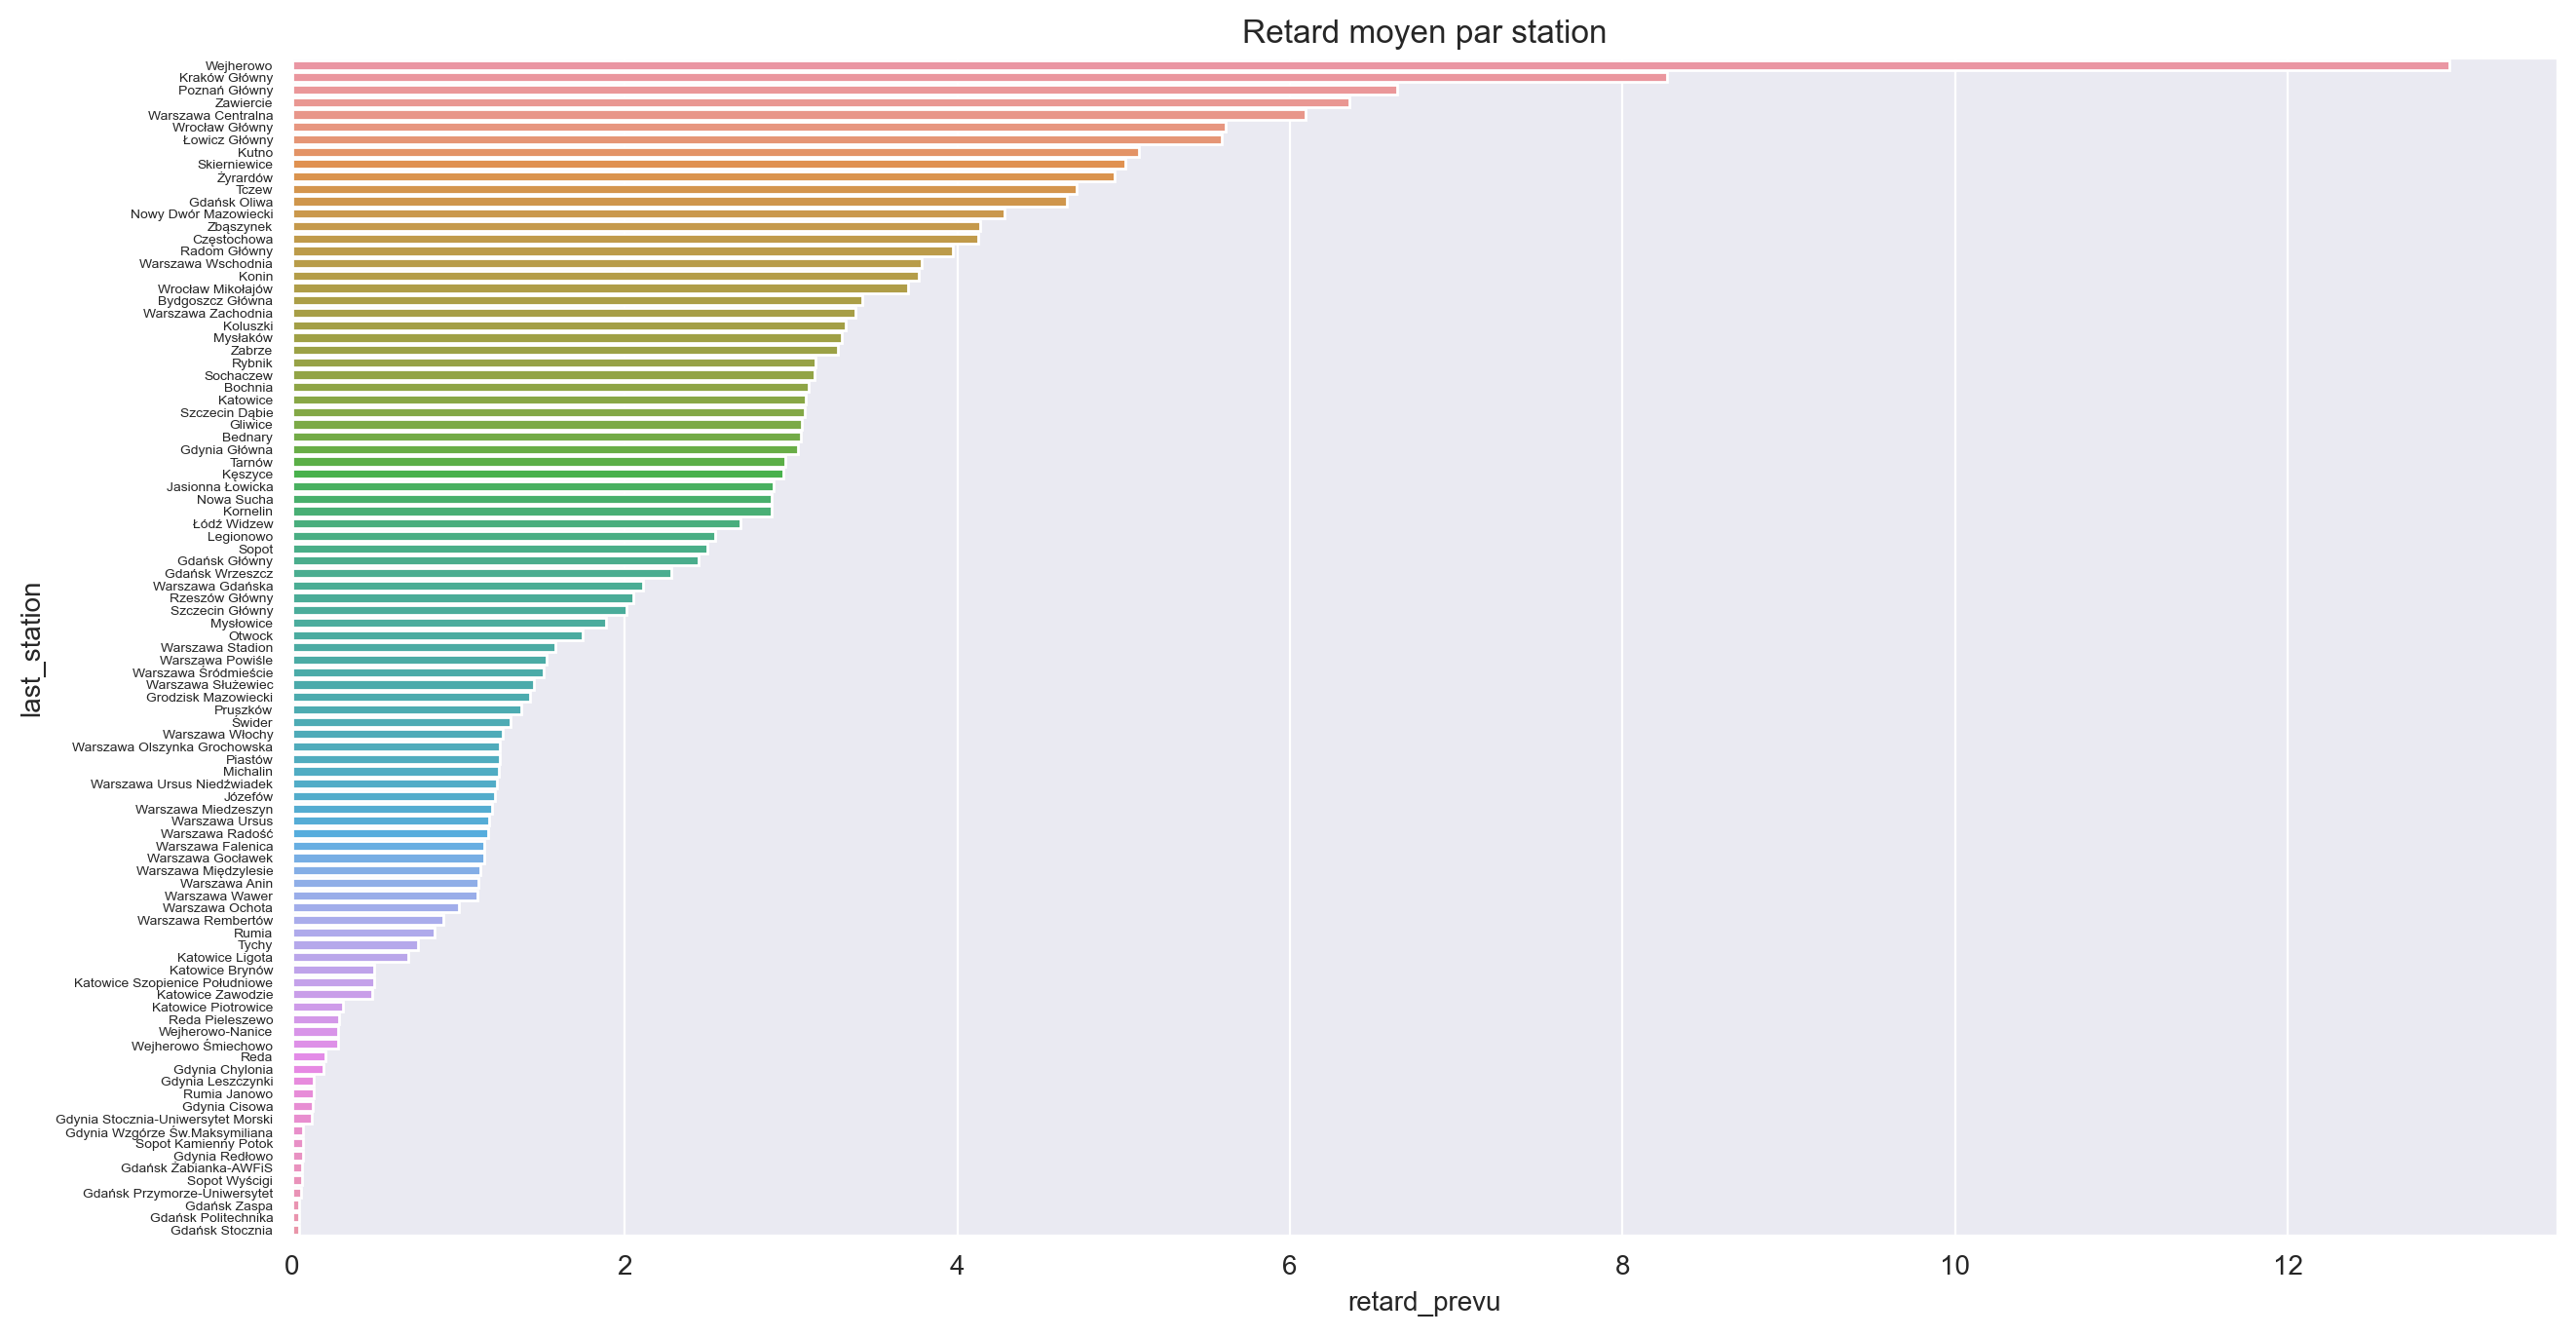

In [225]:
df_temp=df.groupby(["id_train","trajet","last_station"]).agg("mean").groupby("last_station").agg("mean").reset_index().sort_values("retard_prevu",ascending=False)
sns.barplot(data=df_temp,x="retard_prevu",y="last_station")

plt.yticks(fontsize=5)
plt.title("Retard moyen par station")
plt.show()